### 데이콘 주차 수요 예측 데이터를 활용하여 머신러닝 학습 및 예측 수행

In [1]:
import pandas as pd
import numpy as np
import warnings
import seaborn as sns
import matplotlib as plt
warnings.filterwarnings(action='ignore')

In [2]:
df=pd.read_csv('train.csv')
test= pd.read_csv('test.csv')
age_info=pd.read_csv('age_gender_info.csv')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2952 entries, 0 to 2951
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   단지코드                          2952 non-null   object 
 1   총세대수                          2952 non-null   int64  
 2   임대건물구분                        2952 non-null   object 
 3   지역                            2952 non-null   object 
 4   공급유형                          2952 non-null   object 
 5   전용면적                          2952 non-null   float64
 6   전용면적별세대수                      2952 non-null   int64  
 7   공가수                           2952 non-null   float64
 8   자격유형                          2952 non-null   object 
 9   임대보증금                         2383 non-null   object 
 10  임대료                           2383 non-null   object 
 11  도보 10분거리 내 지하철역 수(환승노선 수 반영)  2741 non-null   float64
 12  도보 10분거리 내 버스정류장 수            2948 non-null   float64
 13  단지내

In [3]:
df['임대보증금'][df['임대보증금']=='-']=np.nan
df['임대보증금']=df['임대보증금'].astype('float')
df['임대료'][df['임대료']=='-']=np.nan
df['임대료']=df['임대료'].astype('float')

test['임대보증금'][test['임대보증금']=='-']=np.nan
test['임대보증금']=test['임대보증금'].astype('float')
test['임대료'][test['임대료']=='-']=np.nan
test['임대료']=test['임대료'].astype('float')

df['전용면적'] = df['전용면적']//5*5
test['전용면적'] = test['전용면적']//5*5

### EDA

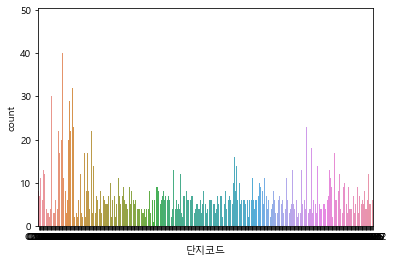

In [4]:
plt.rc('font', family='Malgun Gothic') 
sns.countplot(x= '단지코드', data =df)

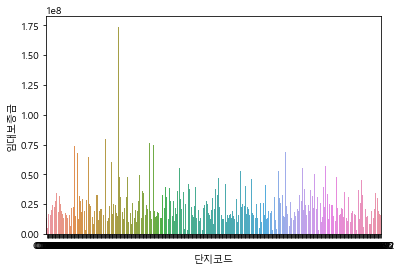

In [5]:
sns.barplot(x=df.groupby('단지코드')['임대보증금'].mean().index,y=df.groupby('단지코드')['임대보증금'].mean())

- 임대보증금의 경우는 특정 하나의 단지코드가 높고 나머지는 편차가 크지 않아서 outlier로 판단됨  
  (모델에 학습할 때 부정적인 영향을 주므로 제거할 필요가 있음)

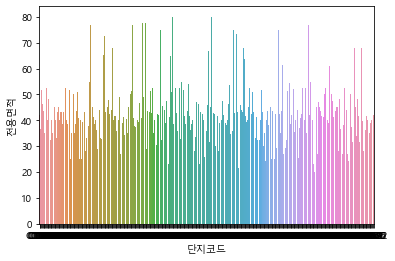

In [6]:
sns.barplot(x=df.groupby('단지코드')['전용면적'].mean().index,y=df.groupby('단지코드')['전용면적'].mean())

- 다만, 상식적으로 전용면적이 크면 보증금도 크기 때문에 동일 단지코드가 전용면적의 편차가 다른 단지에 비해 큰지 파악이 필요함  
    (그러나, 막대그래프로 보아도 전용면적이 비슷한 수준의 단지코드가 많은 것을 확인할 수 있어 면적 때문에 발생된 현상이 아님을 확인할 수 있음)

#### 아웃라이어 데이터 탐색

In [7]:
df.query("단지코드=='C1397'")

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수,등록차량수
2043,C1397,370,아파트,서울특별시,장기전세,20.0,51,9.0,A,87444000.0,NaN,0.0,3.0,1590.0,1595.0
2044,C1397,370,아파트,서울특별시,장기전세,45.0,4,9.0,A,174888000.0,NaN,0.0,3.0,1590.0,1595.0
2045,C1397,370,아파트,서울특별시,장기전세,45.0,69,9.0,A,174888000.0,NaN,0.0,3.0,1590.0,1595.0
2046,C1397,370,아파트,서울특별시,장기전세,50.0,24,9.0,A,194562000.0,NaN,0.0,3.0,1590.0,1595.0
2047,C1397,370,아파트,서울특별시,장기전세,50.0,80,9.0,A,194562000.0,NaN,0.0,3.0,1590.0,1595.0
2048,C1397,370,아파트,서울특별시,장기전세,55.0,142,9.0,A,216423000.0,NaN,0.0,3.0,1590.0,1595.0


In [8]:
# 아웃라이어로 보이는 단지코드 임대보증금 총 세대수 추출
df.groupby('단지코드')['임대보증금'].mean().reset_index().query("임대보증금==173794500")

,단지코드,임대보증금
91,C1397,173794500.0


In [9]:
df.groupby('단지코드')['총세대수'].count().reset_index().query("단지코드=='C1397'")

,단지코드,총세대수
91,C1397,6


In [10]:
# 아웃라이어로 추정되는 단지코드와 같은 총세대수를 가진 단지코드들을 필터링해서 임대보증금을 시각화
a0=df.groupby('단지코드')['총세대수'].count().reset_index().query("총세대수==6").단지코드.unique()
a0=a0.tolist()

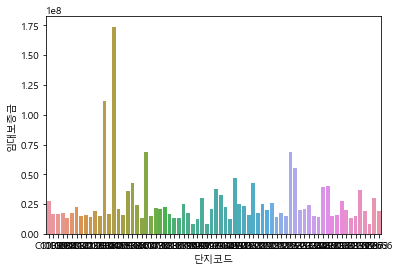

In [11]:
sns.barplot(x=df.query("단지코드 in(@a0)").groupby('단지코드')['임대보증금'].mean().index,y=df.query("단지코드 in(@a0)").groupby('단지코드')['임대보증금'].mean())

In [12]:
df.query("단지코드 in(@a0)").groupby('단지코드')['임대보증금'].mean().sort_values(ascending=False)

단지코드
C1397    1.737945e+08
C1344    1.118005e+08
C2259    6.900000e+07
C1697    6.900000e+07
C2357    5.562167e+07
             ...     
C1969    1.280183e+07
C1907    1.238600e+07
C2627    8.688500e+06
C1925    8.613000e+06
C1899    8.248000e+06
Name: 임대보증금, Length: 72, dtype: float64

- 그래프를 보면 같은 세대수를 가진 건물임에도 임대보증금의 편차가 크고, 그루핑결과로 C1397이 제일 큰 것을 확인

In [13]:
# 비슷한 단지코드를 가진 단지 추출
a1=pd.Series(df.단지코드.unique()).sort_values().iloc[85:100]
a1

246    C1365
94     C1368
196    C1375
169    C1379
170    C1386
214    C1394
274    C1397
322    C1402
250    C1406
2      C1407
197    C1410
20     C1424
284    C1426
230    C1428
57     C1430
dtype: object

In [14]:
a2=df.query("총세대수 > 350 and 총세대수 <400")['단지코드'].unique()
a2

array(['C2073', 'C1850', 'C2216', 'C2232', 'C1973', 'C2133', 'C2390',
       'C1155', 'C1309', 'C1492', 'C2526', 'C1022', 'C2527', 'C1410',
       'C2162', 'C2325', 'C2503', 'C1428', 'C2560', 'C1397', 'C1426',
       'C1788', 'C1089', 'C2661', 'C2539', 'C1048', 'C2143', 'C2153'],
      dtype=object)

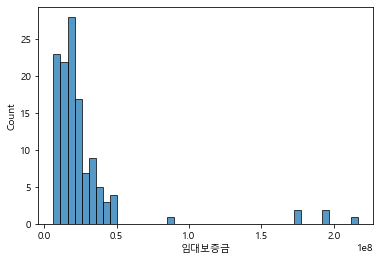

In [15]:
# 아웃라이어와 세대수가 비슷한 단지코드의 총세대수 크기별 빈도 분석
sns.histplot(df.query("총세대수 > 350 and 총세대수 <400")['임대보증금'])

- 임대보증금의 편차가 크다는 것을 알 수 있음
- 아래 그루핑 결과를 보면 히스토그램 제일 우측의 데이터가 C1397임을 알 수 있음

In [16]:
df.query("총세대수 > 350 and 총세대수 <400").groupby('단지코드')['임대보증금'].mean().sort_values(ascending=False)

단지코드
C1397    1.737945e+08
C2143    4.137700e+07
C1155    3.675100e+07
C2527    3.485560e+07
C1788    3.250000e+07
C2390    3.214650e+07
C1048    3.155233e+07
C1973    2.642633e+07
C2133    2.621633e+07
C2232    2.601350e+07
C1022    2.466500e+07
C1428    2.132871e+07
C2162    1.954867e+07
C1309    1.890386e+07
C2560    1.738700e+07
C2073    1.622033e+07
C2503    1.524950e+07
C2325    1.521100e+07
C2539    1.514750e+07
C2526    1.438060e+07
C1850    1.348533e+07
C1089    1.342600e+07
C2661    1.326167e+07
C1492    1.288957e+07
C1410    1.285167e+07
C2153    1.274150e+07
C1426    1.233200e+07
C2216    9.447000e+06
Name: 임대보증금, dtype: float64

In [17]:
# 아웃라이어와 세대코드가 비슷한 1300~1400대에서 세대수도 비슷한 단지코드 추출 
a3=a1.loc[[ i in(a2) for i in a1]]
a3

274    C1397
197    C1410
284    C1426
230    C1428
dtype: object

- 단지코드가 비슷하고 총세대수도 비슷한 단지코드들에서 전용면적과 임대보증금을 비교하기 위해 박스플롯 생성  
    C1397은 대조군과 비교하면 전용면적의 차이에 비해 임대 보증금의 차이가 매우 크므로 아웃라이어로 파악되어 삭제  
    (이는 아래전용면적을 상하한적용하여도 경향성이 바뀌지 않음)

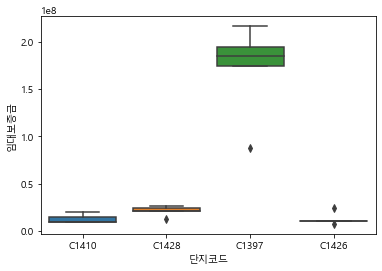

In [18]:
sns.boxplot(x='단지코드',y='임대보증금',data=df.query("단지코드 in @a3"))

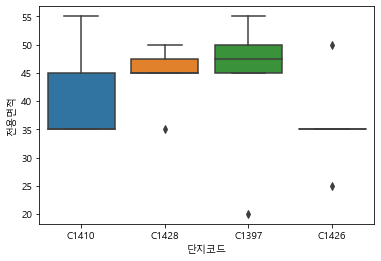

In [19]:
sns.boxplot(x='단지코드',y='전용면적',data=df.query("단지코드 in @a3"))

#### 결론적으로, 전용면적, 세대수 로 볼때 비슷한 그룹임에도 임대보증금이 유달리 높은 C1397를 이상값으로 보고 삭제

In [20]:
df= df.query("단지코드!='C1397'")

#### 전용면적 상하한적용(15~100)

In [21]:
idx = df[df['전용면적']>100].index
df.loc[idx, '전용면적'] = 100
idx = test[test['전용면적']>100].index
test.loc[idx, '전용면적'] = 100

idx = df[df['전용면적']<15].index
df.loc[idx, '전용면적'] = 15
idx = test[test['전용면적']<15].index
test.loc[idx, '전용면적'] = 15

#### 결국 최종 제출을 위해서는 단지코드별 grouping이 필요함. 예제코드에서는 그러한 이유로 차이가
#### 발생하는 변수는 모두 버리고 모델에 학습을 시킴
#### 단지코드별 중복없는게 전용면적, 전용면적별세대수, 임대보증금, 임대료가 있음. 
#### 이경우 한 단지내 개별 집집마다 사용가능한 평수가 다르고 임대료 임대보증금이 다르다는 이야기이기
#### 때문에 이경우에는 최빈값을 따라가는게 상식적으로 옳다고 봄

In [22]:
# 결측치 대치 및 데이터프레임 재선언
df=df.fillna(0)


df1=df[df.columns.difference(['단지코드','등록차량수'])]

r_code=df.단지코드
df1_target=df['등록차량수']

test1=test[test.columns.difference(['단지코드'])]
r_code_t=test.단지코드

df1=pd.merge(df1,age_info,on='지역')
test=pd.merge(test,age_info,on='지역')

#### 표준화 스케일링 진행

In [23]:
from sklearn.preprocessing import StandardScaler

cat_col=[ i for i in df1.columns.values if df1[i].dtype == 'object']

num_col=[ j for j in df1.columns.values if df1[j].dtype in ['int64','float64'] ]

test_cat_col=[ i for i in test1.columns.values if test1[i].dtype == 'object']

test_num_col=[ j for j in test1.columns.values if test1[j].dtype in ['int64','float64'] ]




scaler=StandardScaler()

df1_cat=pd.get_dummies(df1.loc[:,cat_col])
df1_num=pd.DataFrame(scaler.fit_transform(df1.loc[:,num_col]),columns=num_col)

df1_sol=pd.concat([df1_cat,df1_num],axis=1)


test_cat=pd.get_dummies(test.loc[:,test_cat_col])
test_num=pd.DataFrame(scaler.fit_transform(test.loc[:,test_num_col]),columns=test_num_col)

test_sol=pd.concat([test_cat,test_num],axis=1)


len(df1_sol.columns)
len(test_sol.columns)

45

#### test의 범주형 변수의 수가 train데이터보다 작음 변수축소를 해야 모델에 적용가능

In [24]:
df1_sol=df1_sol.reindex(test_sol.columns.values,axis=1)
len(df1_sol.columns)

df1_sol=pd.concat([r_code,df1_sol,df1_target],axis=1)
test_sol=pd.concat([r_code_t,test_sol],axis=1)
#df1_target 이 차량등록수임


df1_sol.dtypes
f1 = lambda x : x.mode().median()

df1_sol=df1_sol.groupby('단지코드').agg(f1).reset_index()

df1_target=df1_sol.등록차량수

df1_sol=df1_sol.iloc[:,1:-1]

test_sol=test_sol.groupby('단지코드').agg(f1).reset_index()
test_sol=test_sol.iloc[:,1:]

#### XGBoost의 회귀모델을 사용하고 최적의 하이퍼파라미터 값을 찾기위해 gridsearch진행

In [25]:
from xgboost import XGBRegressor

xgbreg=XGBRegressor()

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

params= {'max_depth':[2,8,15,20,40],'n_estimators':[10,50,100],'learning_rate':[0.1,0.2,0.3]}
gridcv=GridSearchCV(xgbreg,params,scoring='neg_mean_squared_error',cv=5)

gridcv.fit(df1_sol,df1_target)

gridcv.best_params_
# {'learning_rate': 0.2, 'max_depth': 8, 'n_estimators': 50}

xgbreg=XGBRegressor(learning_rate=0.1,max_depth=2,n_estimators=10)

scores=cross_val_score(xgbreg,df1_sol,df1_target,scoring='neg_mean_squared_error',cv=10)
scores=-scores
scores.mean() 

182338.0874128588

In [26]:
xgbreg.fit(df1_sol,df1_target)
y_pred=xgbreg.predict(test_sol)

##### 제출용 데이터 프레임 생성

In [27]:
submission=pd.read_csv('C:/Users/sanghyun/Desktop/dacon parking/sample_submission.csv')
submission['num']=y_pred


submission.to_csv('baseline.csv', index=False)